<a href="https://colab.research.google.com/github/kumarmanishjha/6135_3/blob/master/Q2_VAE_Importance_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Work in progress !!**

***Task Completed :***

*   Architecture
*   Train VAE
*   Implement ELBO
*   Achieve an ELBO of ≥−96
*   Returns:–(logp(x1),...,logp(xM)) estimates of size (M,)

***To Do:***
* Nothing





In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam
from torch.autograd import Variable
import tensorflow as tf


In [0]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location, filename = filename, md5=None)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [0]:
epochs = 20
bs = 128

train, valid, test = get_data_loader("binarized_mnist", bs)

  0%|          | 0/78400000 [00:00<?, ?it/s]

78405632it [00:09, 7994937.03it/s]                              
  0%|          | 16384/15680000 [00:00<01:37, 161335.67it/s]

15687680it [00:02, 6208347.61it/s]                              
  0%|          | 16384/15680000 [00:00<01:38, 159182.67it/s]

15687680it [00:01, 10690283.65it/s]                             


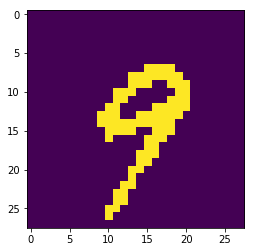

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in train:
    plt.imshow(x[0, 0])
    break

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
  
    def __init__(self, image_channels=1, h_dim=256, z_dim=100):
        super(VAE, self).__init__()
        
        # Q(z|X) -- encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 256, kernel_size=5),
            nn.ELU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        # P(X|z) -- decoder
        self.decoder = nn.Sequential(
            
            UnFlatten(),
            nn.ELU(),
            nn.Conv2d(256, 64, kernel_size= 5, padding= 4),
            nn.ELU(),
            nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True), #, align_corners=True
            nn.Conv2d(64, 32, kernel_size=3, padding=2),
            nn.ELU(),
            nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=True), #, align_corners=True
            nn.Conv2d(32, 16, kernel_size=3, padding = 2),
            nn.ELU(),
            nn.Conv2d(16, image_channels, kernel_size = 3, padding = 2),
            nn.Sigmoid(),
        )
        
        
    def reparameterize(self, mu, logvar):
      
        """std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size())
        z = mu + std * esp"""
        eps = torch.randn(mu.size()).cuda()
        z = eps.mul(logvar.mul(0.5).exp_()).add_(mu)
          
        logq_xz = torch.distributions.MultivariateNormal(mu,  torch.eye(100).cuda())
        q_xz = logq_xz.log_prob(z)
        
        log_p_z = torch.distributions.MultivariateNormal(torch.zeros(100).cuda(), torch.eye(100).cuda())
        p_z = log_p_z.log_prob(z)
                
        return z, q_xz, p_z

    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z, q_xz, p_z = self.reparameterize(mu, logvar)
        return z, q_xz, p_z, mu, logvar

    def forward(self, x):
      
        h = self.encoder(x)
        z, q_xz, p_z, mu, logvar = self.bottleneck(h)
        z_decoder = self.fc3(z)
        decoder = self.decoder(z_decoder)
        
        return decoder, mu, logvar
      
    def imp_sample(self, x, h):
        
        z, q_xz, p_z, mu, logvar = self.bottleneck(h)
        
        z_decoder = self.fc3(z)
        decoder = self.decoder(z_decoder)
        
        log_p_xz = torch.distributions.Bernoulli(decoder.view(decoder.size(0),784))
        p_xz = log_p_xz.log_prob(x.view(x.size(0),784))
        
        return p_xz, q_xz, p_z

        


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model = VAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


criterion = nn.BCELoss(reduction = "sum").cuda()

def loss_fn(recon_x, x, mu, logvar):
    ## E[log P(X|z)]
    
    BCE = criterion(recon_x, x)
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp() )
    return BCE + KLD, BCE, KLD


In [0]:

for epoch in range(epochs):
    total_loss = 0
    total_images = 0
    total_bce = 0
    total_kld = 0 
    for idx, (images) in enumerate(train):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        total_bce += bce.data
        total_kld += kld.data
        total_images += images.size(0)
        
    to_print = "Epoch[{}/{}] ELBO: {:.3f} ,BCE: {:.3f} ,KLD: {:.3f}".format(epoch+1, 
                            epochs, -total_loss/total_images, total_bce/total_images, total_kld/total_images)
    print("Training Data : ", to_print)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Training Data :  Epoch[1/20] ELBO: -213.702 ,BCE: 198.928 ,KLD: 14.773
Training Data :  Epoch[2/20] ELBO: -141.339 ,BCE: 119.012 ,KLD: 22.326
Training Data :  Epoch[3/20] ELBO: -122.331 ,BCE: 99.563 ,KLD: 22.768
Training Data :  Epoch[4/20] ELBO: -113.821 ,BCE: 90.525 ,KLD: 23.296
Training Data :  Epoch[5/20] ELBO: -109.154 ,BCE: 85.163 ,KLD: 23.991
Training Data :  Epoch[6/20] ELBO: -106.210 ,BCE: 81.722 ,KLD: 24.488
Training Data :  Epoch[7/20] ELBO: -104.188 ,BCE: 79.395 ,KLD: 24.792
Training Data :  Epoch[8/20] ELBO: -102.789 ,BCE: 77.800 ,KLD: 24.989
Training Data :  Epoch[9/20] ELBO: -101.674 ,BCE: 76.512 ,KLD: 25.161
Training Data :  Epoch[10/20] ELBO: -100.787 ,BCE: 75.492 ,KLD: 25.295
Training Data :  Epoch[11/20] ELBO: -99.990 ,BCE: 74.612 ,KLD: 25.377
Training Data :  Epoch[12/20] ELBO: -99.346 ,BCE: 73.880 ,KLD: 25.466
Training Data :  Epoch[13/20] ELBO: -98.656 ,BCE: 73.144 ,KLD: 25.512
Training Data :  Epoch[14/20] ELBO: -98.145 ,BCE: 72.562 ,KLD: 25.584
Training Data :  

In [0]:
# Q(z|X) -- encoder
# P(X|z) -- decoder
#p(z) -- latent


In [65]:
#ELBO Validation Data:


epochs = 1


for epoch in range(epochs):
  
    total_loss = 0
    total_images = 0
    total_bce = 0
    total_kld = 0 
    for idx, (images) in enumerate(valid):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)

        total_loss += loss.data
        total_bce += bce.data
        total_kld += kld.data
        total_images += images.size(0)
        
    to_print = "Epoch[{}/{}] ELBO: {:.3f} ,BCE: {:.3f} ,KLD: {:.3f}".format(epoch+1, 
                            epochs, -total_loss/total_images, total_bce/total_images, total_kld/total_images)
    print("Validation Data : ", to_print)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Validation Data :  Epoch[1/1] ELBO: -96.005 ,BCE: 69.294 ,KLD: 26.711


In [66]:
#ELBO Test Data:

for epoch in range(epochs):
  
    total_loss = 0
    total_images = 0
    total_bce = 0
    total_kld = 0 
    for idx, (images) in enumerate(test):
        images = images.to(device)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)

        total_loss += loss.data
        total_bce += bce.data
        total_kld += kld.data
        total_images += images.size(0)
        
    to_print = "Epoch[{}/{}] ELBO: {:.3f} ,BCE: {:.3f} ,KLD: {:.3f}".format(epoch+1, 
                            epochs, -total_loss/total_images, total_bce/total_images, total_images/total_images)
    print("Test Data : ", to_print)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Test Data :  Epoch[1/1] ELBO: -95.211 ,BCE: 68.667 ,KLD: 1.000


In [0]:
#Importance Sampling Function:

def importance_sampling(model, data):
    #Input as our trained model and data
  
    ip_loss = []
    count = 0
    #Setting the model parameters to no_grad
    for param in model.parameters():
        param.requires_grad = False

    for idx, (images) in enumerate(valid):
        images = images.to(device)
        count += 1
        #Calling model to get the output from encoder
        h = model.encoder(images.view(images.size(0),1,28,28))
        h = h.view(images.size(0),256)

        ip_sample = []

        for k in range(200):
            #Calling model to get output of our densities :
            p_xz, q_xz, p_z = model.imp_sample(images, h)
            #Summing over 784 dimention and the dimention we will have (1XBatch_Size)
            p_xz = torch.sum(p_xz,dim=1)
            #Importance Sampling calculation with LogSumExp trick:
            out = p_xz - q_xz + p_z
            log_weight = out - torch.max(out, 0)[0]
            weight = torch.exp(log_weight)
            weight = weight / torch.sum(weight, 0)
            loss = torch.mean(torch.sum(weight * (p_z + p_xz - q_xz), 0))
            ip_sample.append(loss)

        ip_loss.append(torch.sum(torch.stack(ip_sample))/bs)

    print("Importance Sampling over mini batch -", count,' : ' , torch.stack(ip_loss))

    log_likelihood_estimate = torch.mean(torch.stack(ip_loss))
    print('log-likelihood  estimate :', log_likelihood_estimate)
    
        

In [0]:
#Importance Sampling on Validation Data:
importance_sampling(model, valid)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Importance Sampling over mini batch - 79  :  tensor([-51.7519, -40.9928, -41.9688, -46.6459, -42.4130, -38.6475, -49.3180,
        -51.9250, -49.2326, -47.2400, -49.1583, -43.8565, -43.8202, -44.8767,
        -43.7532, -42.8402, -46.4243, -49.3233, -43.2348, -49.6836, -44.7124,
        -46.7302, -48.0831, -49.9344, -47.7950, -45.1786, -47.8287, -46.6879,
        -46.1231, -44.2850, -44.0064, -49.5948, -46.6224, -43.1792, -42.5128,
        -41.6820, -47.1679, -43.5925, -44.8092, -48.2863, -50.3733, -42.4824,
        -46.2240, -43.1253, -43.3580, -42.5984, -42.1227, -46.7130, -44.9543,
        -49.1215, -47.8726, -45.6109, -35.2775, -44.2597, -49.3639, -47.0719,
        -45.0195, -43.1482, -45.8838, -48.7599, -44.1559, -48.9082, -43.0310,
        -44.1631, -47.1068, -51.6412, -47.2906, -41.0335, -46.9298, -45.2434,
        -45.7410, -44.8673, -42.7586, -47.2907, -50.1011, -45.3172, -41.2663,
        -49.9883, -93.6936], device='cuda:0')
log-likelihood  estimate : tensor(-46.3264, device=

In [62]:
#Importance Sampling on Test Data:
importance_sampling(model, test)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Importance Sampling over mini batch - 79  :  tensor([-52.7230, -38.5022, -41.5454, -44.8406, -42.1316, -39.2519, -48.6957,
        -52.1163, -49.4720, -48.8493, -48.6751, -43.5811, -45.4943, -44.7466,
        -43.0537, -42.2316, -45.8955, -48.1179, -41.5966, -46.0453, -44.4864,
        -46.6894, -48.7502, -49.4452, -45.5944, -42.2726, -45.6959, -47.1088,
        -46.0568, -43.9493, -40.0193, -48.3433, -46.4479, -43.6426, -41.9381,
        -39.0924, -47.6184, -44.0960, -43.6848, -47.2630, -48.8614, -41.6990,
        -46.9828, -42.6285, -40.8621, -42.3729, -40.9367, -43.7882, -44.5581,
        -49.4060, -48.0522, -47.0951, -34.7636, -44.6727, -49.9396, -47.3049,
        -44.7363, -43.8361, -45.1213, -48.0192, -43.4353, -50.8232, -41.6098,
        -42.8519, -46.1503, -51.6169, -47.4296, -40.6439, -46.2924, -45.4969,
        -43.3647, -43.7505, -42.3943, -45.9587, -50.8289, -44.2461, -43.2137,
        -49.3374, -89.8843], device='cuda:0')
log-likelihood  estimate : tensor(-45.7560, device=